In [110]:
import pandas as pd
pd.pandas.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

from helper_functions import *
import pickle

### 1. Load Data

In [15]:
ca_df = pd.read_csv('../data/ca_supervised.csv')
ca_df.head()

,date,item_sales,sales_diff,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
0,2012-02-01,13982.413793,970.187987,114.967742,519.391398,-729.649462,1064.382796,383.907527,-24.096774,585.055914,725.169892,-660.369892,76.111828,-403.395161,-1341.916667
1,2012-03-01,14516.741935,534.328142,970.187987,114.967742,519.391398,-729.649462,1064.382796,383.907527,-24.096774,585.055914,725.169892,-660.369892,76.111828,-403.395161
2,2012-04-01,14366.566667,-150.175269,534.328142,970.187987,114.967742,519.391398,-729.649462,1064.382796,383.907527,-24.096774,585.055914,725.169892,-660.369892,76.111828
3,2012-05-01,14277.354839,-89.211828,-150.175269,534.328142,970.187987,114.967742,519.391398,-729.649462,1064.382796,383.907527,-24.096774,585.055914,725.169892,-660.369892
4,2012-06-01,15794.866667,1517.511828,-89.211828,-150.175269,534.328142,970.187987,114.967742,519.391398,-729.649462,1064.382796,383.907527,-24.096774,585.055914,725.169892


### 2. Train Test Split

In [17]:
train, test = train_test_spli(ca_df)
train.shape, test.shape

((40, 13), (12, 13))

### 3. Scale and Split into X & y

In [19]:
X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((40, 12), (40,), (12, 12), (12,))

### 4. Linear Regression

In [95]:
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)

x_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
x_test.shape, y_pred.shape

((12, 1, 12), (12, 1, 1))

In [96]:
pred_test_set = []
for index in range(0,len(y_pred)):
    pred_test_set.append(np.concatenate([y_pred[index], x_test[index]], axis=1))

In [97]:
pred_test_set = np.array(pred_test_set)
pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])

In [98]:
pred_test_set_inverted = scaler_object.inverse_transform(pred_test_set)
pred_test_set_inverted.shape

(12, 13)

In [99]:
pred_test_set_inverted[0]

array([  261.94110354,   374.89139785,    66.26989247,   294.56105991,
         278.14861751,   827.32258065, -1358.23548387,  -239.21612903,
        -652.85053763,  -596.69784946,   313.03225806,    40.6655914 ,
         721.39892473])

In [100]:
df = load_data('ca')
df.head()

,date,item_sales
0,2012-02-01,13982.413793
1,2012-03-01,14516.741935
2,2012-04-01,14366.566667
3,2012-05-01,14277.354839
4,2012-06-01,15794.866667


In [101]:
results = []
dates = list(df[-13:].date)
item_sales = list(df[-13:].item_sales)

for idx in range(0, len(pred_test_set_inverted)):
    result_dict = {}
    result_dict['pred_value'] = int(pred_test_set_inverted[idx][0] + item_sales[idx])
    result_dict['date'] = dates[idx + 1]
    results.append(result_dict)
    
result_df = pd.DataFrame(results)
result_df

,pred_value,date
0,16059,2015-06-01
1,17342,2015-07-01
2,17894,2015-08-01
3,18252,2015-09-01
4,17203,2015-10-01
5,17144,2015-11-01
6,15721,2015-12-01
7,15506,2016-01-01
8,16912,2016-02-01
9,17714,2016-03-01


RMSE: 734.0659554863445
R2 Score: 0.3706779436937887


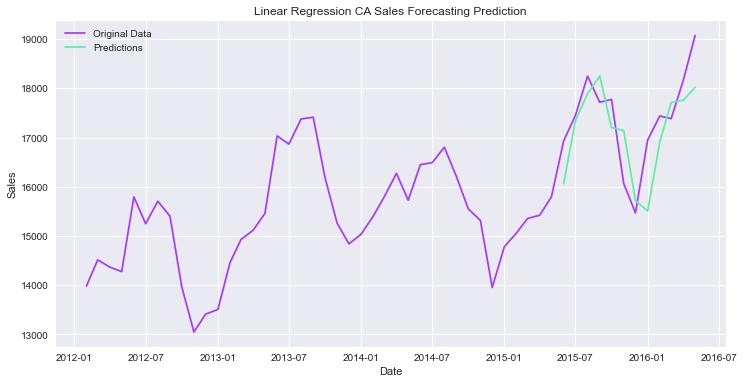

In [109]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(df.date, df.item_sales, data=df, label='Original Data', ax=ax, color=gen_random_color())
sns.lineplot(result_df.date, result_df.pred_value, data=result_df, label='Predictions', ax=ax, color=gen_random_color());
ax.set(xlabel = "Date", ylabel = "Sales", title = f"Linear Regression CA Sales Forecasting Prediction")
plt.savefig(f'../images/ca_linear_regresion_forecast.png')

model_scores = {}

rmse = np.sqrt(mean_squared_error(df.item_sales[-12:], result_df.pred_value[-12:]))
r2 = r2_score(df.item_sales[-12:], result_df.pred_value[-12:])
model_scores['Linear Regression'] = [rmse, mae, r2]

print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")